In [7]:
from utils_methods import raydepth2depth, load_color_image, load_depth_map, load_normal_map, compute_variation, sobel_line_neighborhood, overlay_lines_on_image_custom
from upload_hypersim import upload_images 
import os
import numpy as np
from numpy import linalg as LA
import cv2
import torch
import h5py
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5'
position_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.position.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])
with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])
with h5py.File(position_path, "r") as f:
    world_coordinates = np.array(f["dataset"])

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
world_coordinates = world_coordinates.astype(np.float32)

# Initialize DeepLSD model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {'detect_lines': True, 'line_detection_params': {'merge': False, 'filtering': True, 'grad_thresh': 3}}
ckpt = torch.load('../weights/deeplsd_md.tar', map_location='cpu', weights_only=False)
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()



[Parameter Comparison] Processing image: ai_001_001 for frame 0001
data/ai_001_001/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg
data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_world.hdf5
data/ai_001_001/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5
[Neighborhood Method] ai_001_001: Detected 398 lines; 60 classified as structural.


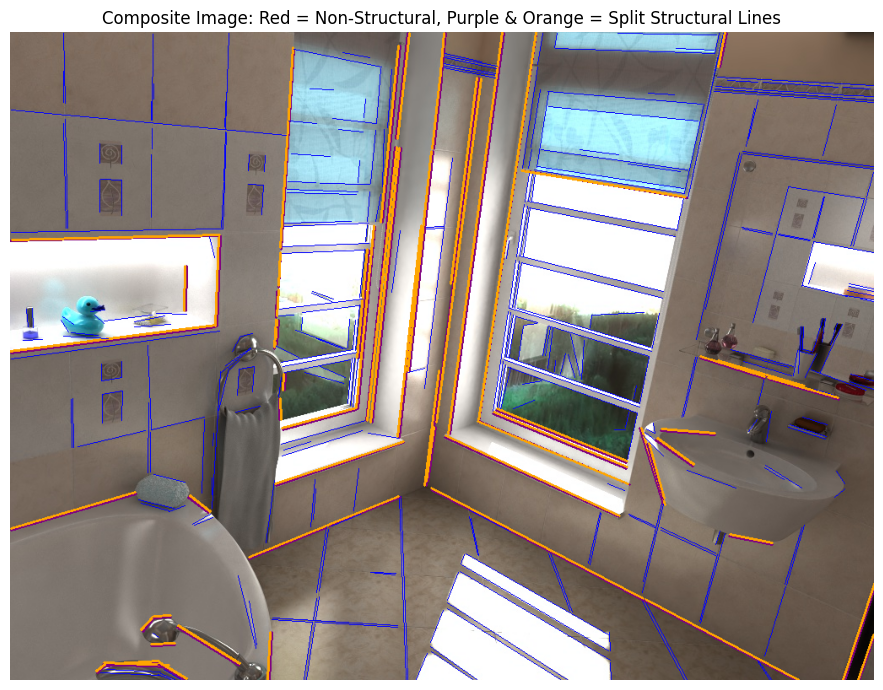


[Parameter Comparison] Processing image: ai_001_004 for frame 0001

[Parameter Comparison] Processing image: ai_001_005 for frame 0001

[Parameter Comparison] Processing image: ai_001_006 for frame 0001

[Parameter Comparison] Processing image: ai_001_007 for frame 0001

[Parameter Comparison] Processing image: ai_001_008 for frame 0001

[Parameter Comparison] Processing image: ai_001_009 for frame 0001

[Parameter Comparison] Processing image: ai_002_001 for frame 0001

[Parameter Comparison] Processing image: ai_002_003 for frame 0001

[Parameter Comparison] Processing image: ai_002_004 for frame 0001

[Parameter Comparison] Processing image: ai_002_005 for frame 0001

[Parameter Comparison] Processing image: ai_002_006 for frame 0001


In [11]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import os

def process_image(image_dir, image_id, frame_str, net, device,
                  depth_thresh, normal_thresh, thickness,
                  method="neighborhood", depth_normal_func=np.max,
                  depth_normal_func_str="Max", norm_agg_func=np.sum,
                  struct_color=(0, 0, 255), text_color=(255, 0, 0)):
    """
    Process a single image and plot the composite image with non-structural lines in red 
    and with each structural line replaced by two new thin lines drawn in purple and orange.
    
    Non-structural lines are drawn using text_color (red).
    For each structural line, two new thin lines are defined by offsetting the original 
    line by a very small amount in the direction that maximizes the difference between 
    the normals sampled on the two lines. Both new lines have exactly the same length 
    as the original.
    
    Returns:
        composite_after (numpy array): Composite image with drawn lines.
        new_lines (numpy array): Array of all new lines, each with shape (2,2).
                                For a structural line, the two new lines are included;
                                non-structural lines are included as they were detected.
    """
    # Load image data (assumes these helper functions are implemented)
    cam_view_color = "scene_cam_00_final_preview"
    cam_view_geom = "scene_cam_00_geometry_hdf5"

    color_img = load_color_image(image_dir, image_id, frame_str, cam_view_color)
    normal_map = load_normal_map(image_dir, image_id, frame_str, cam_view_geom)
    depth_map = load_depth_map(image_dir, image_id, frame_str, cam_view_geom)
    
    if color_img is None or depth_map is None or normal_map is None:
        print(f"Missing data in {image_dir}; skipping processing.")
        return None, None

    h, w = color_img.shape[:2]
    fov_x = np.pi / 3 
    f = w / (2 * np.tan(fov_x / 2))
    default_K = np.array([[f, 0, w / 2], [0, f, h / 2], [0, 0, 1]])
    
    depth_map = raydepth2depth(depth_map, default_K)
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
    
    # Detect lines with DeepLSD.
    input_tensor = torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.
    with torch.no_grad():
        out = net({'image': input_tensor})
        pred_lines = out['lines'][0]
        # Ensure lines are in numpy format.
        if isinstance(pred_lines, torch.Tensor):
            pred_lines = pred_lines.cpu().numpy()
    
    # Compute variation maps for depth and normal.
    sobel_depth_map = compute_variation(depth_map, 11)
    sobel_normal_map = compute_variation(normal_map, 27)
    sobel_normal_map = norm_agg_func(sobel_normal_map, axis=2)
        
    # Classify each predicted line as structural or non-structural.
    is_struct = []
    for l in pred_lines:
        # Lines are expected to be of shape (2,2) or (4,).
        if l.shape == (4,):
            line_for_class = l.reshape(2, 2)
        else:
            line_for_class = l
        ld_neigh, ln_neigh = sobel_line_neighborhood(sobel_depth_map, sobel_normal_map, line_for_class, thickness=thickness)
        max_depth = depth_normal_func(ld_neigh)
        max_normal = depth_normal_func(ln_neigh)
        depth_bool = max_depth > depth_thresh
        normal_bool = max_normal > normal_thresh
        is_struct.append(depth_bool or normal_bool)

    print(f"[{method.capitalize()} Method] {os.path.basename(image_dir)}: Detected {len(pred_lines)} lines; {sum(is_struct)} classified as structural.")

    # Define colors:
    # Non-structural: text_color (red).
    non_structural_color = text_color
    # Structural new lines: first new line purple, second new line orange.
    structural_color1 = (128, 0, 128)  # purple
    structural_color2 = (0, 165, 255)   # orange

    # Create composite image.
    composite_after = color_img.copy()

    # List to store new lines.
    new_lines_list = []

    def create_optimal_offset_lines(line, normal_map, offset_amount=1.0, num_samples=100, angle_steps=36):
        """
        For a given structural line (with endpoints in a (2,2) array) and normal_map,
        search over candidate translation directions. For each candidate direction, 
        offset the line by ± offset_amount and sample normals along the resulting lines.
        Return the pair of lines (each with the same endpoints length as the original) 
        that maximizes the sum of Euclidean distances between normals at corresponding points.
        """
        p1, p2 = line
        xs = np.linspace(p1[0], p2[0], num_samples)
        ys = np.linspace(p1[1], p2[1], num_samples)
        best_score = -np.inf
        best_d = None
        for theta in np.linspace(0, np.pi, angle_steps, endpoint=False):
            d = np.array([np.cos(theta), np.sin(theta)])
            # Compute sample points on both offset lines.
            pts1 = np.stack([xs, ys], axis=1) + offset_amount * d
            pts2 = np.stack([xs, ys], axis=1) - offset_amount * d
            H, W = normal_map.shape[:2]
            normals1 = []
            normals2 = []
            # Sample normals from the normal_map for both candidate lines.
            for pt in pts1:
                x = int(round(pt[0]))
                y = int(round(pt[1]))
                x = np.clip(x, 0, W-1)
                y = np.clip(y, 0, H-1)
                normals1.append(normal_map[y, x, :])
            for pt in pts2:
                x = int(round(pt[0]))
                y = int(round(pt[1]))
                x = np.clip(x, 0, W-1)
                y = np.clip(y, 0, H-1)
                normals2.append(normal_map[y, x, :])
            normals1 = np.array(normals1)
            normals2 = np.array(normals2)
            # Compute the sum of Euclidean distances between corresponding normals.
            diffs = np.linalg.norm(normals1 - normals2, axis=1)
            score = np.sum(diffs)
            if score > best_score:
                best_score = score
                best_d = d
        # With the best translation direction, create the two new lines.
        new_line1 = np.array([p1 + offset_amount * best_d, p2 + offset_amount * best_d])
        new_line2 = np.array([p1 - offset_amount * best_d, p2 - offset_amount * best_d])
        return new_line1, new_line2

    # Iterate over all detected lines and draw them.
    for i, l in enumerate(pred_lines):
        if l.shape == (4,):
            line = l.reshape(2, 2)
        else:
            line = l

        if is_struct[i]:
            # For structural lines, determine the optimal offset lines.
            offset_amount = 1.0  # very small offset for thin lines
            line1, line2 = create_optimal_offset_lines(line, normal_map, offset_amount=offset_amount)
            # Record the new lines.
            new_lines_list.append(line1)
            new_lines_list.append(line2)
            # Optionally, use a slightly thicker drawing to keep the lines contiguous.
            new_thickness = thickness + 1
            cv2.line(composite_after,
                     (int(round(line1[0, 0])), int(round(line1[0, 1]))),
                     (int(round(line1[1, 0])), int(round(line1[1, 1]))),
                     structural_color1, new_thickness)
            cv2.line(composite_after,
                     (int(round(line2[0, 0])), int(round(line2[0, 1]))),
                     (int(round(line2[1, 0])), int(round(line2[1, 1]))),
                     structural_color2, new_thickness)
        else:
            # For non-structural lines, draw in red and add the original line.
            new_lines_list.append(line)
            cv2.line(composite_after,
                     (int(round(line[0, 0])), int(round(line[0, 1]))),
                     (int(round(line[1, 0])), int(round(line[1, 1]))),
                     non_structural_color, thickness)

    # Convert list of new lines to a NumPy array.
    new_lines_array = np.array(new_lines_list)
        # === Plot the composite image (non-structural in red, structural segments in purple and orange) ===
    plt.figure(figsize=(10, 7))
    plt.imshow(cv2.cvtColor(composite_after, cv2.COLOR_BGR2RGB))
    plt.title("Composite Image: Red = Non-Structural, Purple & Orange = Split Structural Lines")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    # Return both the composite image and the array of new lines.
    return composite_after, new_lines_array



# Define what to import
frame_str = "0001"
# images
desired_images = [
    "ai_001_001",
    "ai_001_004",
    "ai_001_005",
    "ai_001_006",
    "ai_001_007",
    "ai_001_008",
    "ai_001_009",
    "ai_002_001",
    "ai_002_003",
    "ai_002_004",
    "ai_002_005",
    "ai_002_006",
]
#files
files_to_download = [
    f"frame.{frame_str}.color.jpg",
    f"frame.{frame_str}.depth_meters.hdf5",
    f"frame.{frame_str}.normal_world.hdf5",
    f"frame.{frame_str}.normal_bump_world.hdf5",
    f"frame.{frame_str}.position.hdf5"
]

# Define the data directory and the images to process
# Define arrays for each parameter
depth_thresholds = 0.9     
normal_thresholds = 0.30*1e11    #Too high
thickness_values = 1 

base_data_dir = "data"
image_ids = desired_images
pred_lines = None
for i,image_id in enumerate(image_ids):
    image_dir = os.path.join(base_data_dir, image_id)
    print(f"\n[Parameter Comparison] Processing image: {image_id} for frame {frame_str}")
    if i == 0:
        composite_after,pred_lines = process_image(image_dir, image_id, frame_str, net, device,
                                        depth_thresholds, normal_thresholds, thickness_values, depth_normal_func=np.mean,depth_normal_func_str="Mean",norm_agg_func=LA.norm)


/var/folders/m2/lbk735w547j5jf8nwvk8vnj40000gn/T/ipykernel_56462/468417269.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))


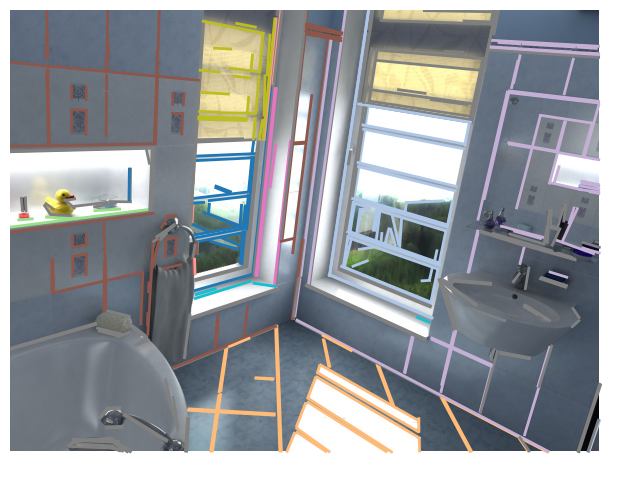

In [12]:
import numpy as np
import scipy.spatial.distance as dist


def mahalanobis_outlier_removal(normals, threshold=3.0):
    normals = np.array(normals)

    if normals.shape[0] < 3:  # Not enough data points
        return normals

    mean = np.mean(normals, axis=0)
    cov_matrix = np.cov(normals.T)

    # Regularization to avoid singular matrix
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6

    # Use pseudo-inverse if still singular
    try:
        inv_cov_matrix = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov_matrix = np.linalg.pinv(cov_matrix)

    distances = np.array([dist.mahalanobis(n, mean, inv_cov_matrix) for n in normals])
    return normals[distances < threshold]

def compute_average_plane(points, normals):
    """
    Compute an average plane equation ax + by + cz + d = 0 
    for a set of 3D points and their corresponding normal vectors.

    Parameters:
    
    points (np.ndarray): Nx3 array of 3D points along a line.
    normals (np.ndarray): Nx3 array of normal vectors at each point.

        Returns:
        
    np.ndarray: Plane equation coefficients [a, b, c, d]."""
    if len(points) < 3:
        return None  # Not enough points to define a plane
    
    filtered_normals_dbscan = mahalanobis_outlier_removal(normals, threshold=1.5) #thickness2: eps=0.2, thickness3: eps=0.5

    # Compute the average normal vector
    avg_normal = np.mean(filtered_normals_dbscan, axis=0)
    avg_normal /= np.linalg.norm(avg_normal)  # Normalize it

    # Compute the average point on the line
    avg_point = np.mean(points, axis=0)

    # Compute d using the plane equation formula: ax + by + cz + d = 0
    a, b, c = avg_normal
    d = -np.dot(avg_normal, avg_point)

    return np.array([a, b, c, d])  # Return plane coefficients
def get_line_pixels(line, maps):
    """
    Get all pixel coordinates along a line using cv2.line.
    """
    x1, y1 = map(int, line[0])
    x2, y2 = map(int, line[1])
    height, width = maps.shape[:2]

    blank_image = np.zeros((height, width), dtype=np.uint8)
    cv2.line(blank_image, (x1, y1), (x2, y2), color=255, thickness=3)
    
    y_coords, x_coords = np.where(blank_image == 255)
    return list(zip(x_coords, y_coords))

def extract_line_features(lines, normal_map, world_coordinates):
    """
    Extract spatial and normal features for each line.
    """
    line_features = []
    for line in lines:
        pixel_coords = get_line_pixels(line, depth_map)

        points, normals = [], []
        for x, y in pixel_coords:
            points.append(world_coordinates[y, x])
            normals.append(normal_map[y, x])

        if len(points) > 2:
            plane = compute_average_plane(np.array(points), np.array(normals))
            if plane is not None:
                line_features.append(plane)

    return np.array(line_features, dtype=object)

def cluster_coplanar_lines(line_features, eps=0.5, min_samples=5):
    """
    Cluster coplanar lines using DBSCAN.
    """
    if len(line_features) == 0:
        return []

    # Feature vector: (plane normal x, y, z, centroid x, y, z)
    # feature_matrix = np.array([np.hstack((plane[:3], centroid)) for plane, centroid, _ in line_features])
    feature_matrix = line_features
    # DBSCAN Clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(feature_matrix)
    return clustering.labels_

# Extract features
line_features = extract_line_features(pred_lines, normal_map, world_coordinates)


# Apply DBSCAN
coplanar_clusters = cluster_coplanar_lines(line_features, min_samples=4, eps=0.2) #thickness2: eps=0.6, thickness3: eps=0.2 

# Visualization Function
def plot_coplanar_lines(lines, labels, image):
    unique_labels = set(labels)
    colors = plt.cm.get_cmap("tab20", len(unique_labels))

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for idx, line in enumerate(lines):
        label = labels[idx]
        if label == -1:  # Outliers
            color = 'grey'
        else:
            color = colors(label)[:3]  # Get unique color

        plt.plot([line[0, 0], line[1, 0]], [line[0, 1], line[1, 1]], color=color, linewidth=2)
    plt.axis("off")
    plt.show()

# Plot results
plot_coplanar_lines(pred_lines, coplanar_clusters, img)